<a href="https://colab.research.google.com/github/carlgran/SIIM_ISIC_Competition/blob/master/SIIM_ISIC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pwd

/content


In [2]:
# TO RUN WITH GOOGLE DRIVE DATA

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


****
##Preprocessing

In [3]:
# LOAD LIBRARIES
import numpy as np, pandas as pd, os
import matplotlib.pyplot as plt, cv2
from sklearn.impute import SimpleImputer
import tensorflow as tf, re, math
import time

meta_train = pd.read_csv('drive/My Drive/SIIM_data/train.csv')
meta_test =pd.read_csv('drive/My Drive/SIIM_data/test.csv')#/drive/My Drive/SIIM_data/test.csv
sample_sub = pd.read_csv('drive/My Drive/SIIM_data/sample_submission.csv')

y = meta_train.target

# COMBINE TRAIN AND TEST TO ENCODE TOGETHER
cols = meta_test.columns
comb = pd.concat([meta_train[cols],meta_test[cols]],ignore_index=True,axis=0).reset_index(drop=True)

# LABEL ENCODE ALL STRINGS
cats = ['patient_id','sex','anatom_site_general_challenge'] 
for c in cats:
    comb[c],mp = comb[c].factorize()
    #print(mp)
#print('Imputing Age NaN count =',comb.age_approx.isnull().sum())
comb.age_approx.fillna(comb.age_approx.mean(),inplace=True)
comb['age_approx'] = comb.age_approx.astype('int')

# REWRITE DATA TO DATAFRAMES
meta_train[cols] = comb.loc[:meta_train.shape[0]-1,cols].values
meta_test[cols] = comb.loc[meta_train.shape[0]:,cols].values
meta_train.diagnosis.value_counts()

unknown                               27124
nevus                                  5193
melanoma                                584
seborrheic keratosis                    135
lentigo NOS                              44
lichenoid keratosis                      37
solar lentigo                             7
cafe-au-lait macule                       1
atypical melanocytic proliferation        1
Name: diagnosis, dtype: int64

****

##Training with Logistic Regression in scikit-learn

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_curve, auc

X = meta_train[cols]

X.drop(["image_name"], axis=1, inplace=True)#X.drop(["image_name", "patient_id"], axis=1, inplace=True)#

# Train-validation split

X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.2, test_size=0.2, random_state=0)
clf = LogisticRegression(random_state=0).fit(X_train, y_train)

# Predict probability target
y_pred_p = clf.predict_proba(X_val)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


###Optimize F_1 score

In [5]:
prob_thr = np.arange(0.01,0.13,0.001)
f1_scores = []
for pt in prob_thr:
    y_predict = [1 if a[1]>=pt else 0 for a in y_pred_p ]
    f1_scores.append(f1_score(y_val, y_predict))
    #print(y_predict.count(1), f1_score(y_val, y_predict), pt )
max_f1 = np.max(f1_scores) 
c_pt = prob_thr[f1_scores.index(max_f1)]

print('max f1_score:%s'%max_f1, '\nthreshold prob:%s%%'%(np.round(c_pt*100)))
y_predict = [1 if a[1]>=c_pt else 0 for a in y_pred_p ]


max f1_score:0.13937282229965156 
threshold prob:6.0%


###ROC and AUC score

AUC:0.69517


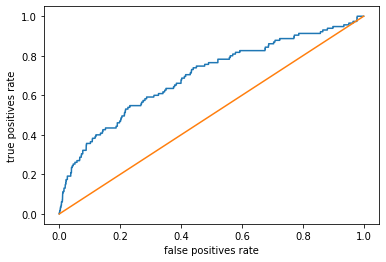

In [6]:
y_pred_p[:,1]
fpr, tpr, thresholds = roc_curve(y_val, y_pred_p[:,1], pos_label=None)
plt.plot(fpr,tpr)
plt.xlabel('false positives rate')
plt.ylabel('true positives rate')
plt.plot(fpr,fpr)
print('AUC:%s'%np.round(auc(fpr, tpr),5))

### Test for submission

In [7]:
X_test = meta_test[cols]

X_test.drop(["image_name"], axis=1, inplace=True)

y_test_p = clf.predict_proba(X_test)

sample_sub.target = y_test_p[:,1]

sample_sub.to_csv("drive/My Drive/SIIM_data/submission.csv", index=False)

sample_sub.tail()

,image_name,target
10977,ISIC_9992485,0.045063
10978,ISIC_9996992,0.031080
10979,ISIC_9997917,0.024727
10980,ISIC_9998234,0.102490
10981,ISIC_9999302,0.030065


*****

##Training with Keras model in TensorFlow

In [8]:
# Customize loss functions

import tensorflow.keras.backend as K
from tensorflow.keras.utils import to_categorical

# F_1 Score:

def f1(y_true, y_pred):
    y_pred = K.round(y_pred)#K.round(y_pre[:,1])
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1[-1:])

def f1_loss(y_true, y_pred):
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return 1 - K.mean(f1[-1:])

In [9]:
X_NN = X
X_NN.drop(['patient_id'], axis=1, inplace=True)
X.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,sex,age_approx,anatom_site_general_challenge
0,0,45,0
1,1,45,1
2,1,50,2
3,1,45,0
4,1,55,1


In [10]:
#Build and compile model

from tensorflow.keras.layers import Input, Dense, Activation,Dropout
from tensorflow.keras.models import Model

y_binary = to_categorical(y) #Encode target

X_train, X_val, y_train, y_val = train_test_split(X_NN, y_binary, train_size=0.8, test_size=0.2, random_state=0)

input_layer = Input(shape=(X.shape[1],))
dense_layer_1 = Dense(5, activation='relu')(input_layer)
dense_layer_2 = Dense(10, activation='relu')(dense_layer_1)
output = Dense(y_binary.shape[1], activation='softmax')(dense_layer_1)#(input_layer)#

model = Model(inputs=input_layer, outputs=output)
model.compile(loss=f1_loss, optimizer='adam', metrics=['acc', f1])
print(model.summary())
#print(model.compile.__doc__)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3)]               0         
_________________________________________________________________
dense (Dense)                (None, 5)                 20        
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 12        
Total params: 32
Trainable params: 32
Non-trainable params: 0
_________________________________________________________________
None


In [11]:
history = model.fit(X_train, y_train, batch_size=200, epochs=100, verbose=0, validation_split=0.3)

In [12]:
# Validate

score = model.evaluate(X_val, y_val, verbose=1)
y_p = model.predict(X_val)

#y_true, y_pred = np.argmax(y_val, axis=1), np.argmax(y_p, axis=1)

#plt.scatter(X_val['age_approx'],y_pred)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])
print("F_1 score:",  f1(y_val, y_p).numpy())

208/208 [==============================] - 0s 992us/step - loss: 0.9413 - acc: 0.9279 - f1: 0.0584
Test Score: 0.9412721991539001
Test Accuracy: 0.9278599619865417
F_1 score: 0.09125472


AUC score:0.6942011178407109


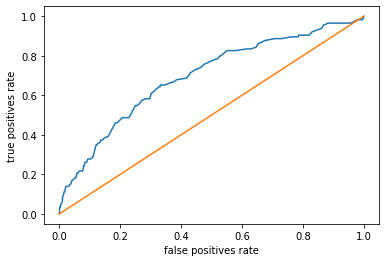

In [13]:
# ROC and AUC score
y_val_pos = [a[1] for a in y_val ]
y_p_pos = [a[1] for a in y_p ]

fpr, tpr, thresholds = roc_curve(y_val_pos, y_p_pos, pos_label=None)

plt.xlabel('false positives rate')
plt.ylabel('true positives rate')
plt.plot(fpr,tpr)
plt.plot(fpr,fpr)
print("AUC score:%s"%auc(fpr, tpr))


In [14]:
# # check target
# ct=0
# for a in y_p:
#     ct+=1
#     if a[1]>=0.5:
#         print(a,ct, y_val[ct-1])


****
##Working with tfrec files

####Functions for reading TFRecord  files

See verify Tfrecord section of [this notebook](https://www.kaggle.com/cdeotte/how-to-create-tfrecords)

In [15]:
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size needed for TPU
    return image

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "image_name": tf.io.FixedLenFeature([], tf.string),  # shape [] means single element
        "target": tf.io.FixedLenFeature([], tf.int64)
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = example['image_name']
    target = example['target']
    return image, label, target # returns a dataset of (image, label) pairs

def load_dataset(filenames, labeled=True, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord)
    # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset

def get_training_dataset():
    dataset = load_dataset(TRAINING_FILENAMES, labeled=True)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

In [16]:
# INITIALIZE VARIABLES
IMAGE_SIZE= [1024,1024]; BATCH_SIZE = 1
AUTO = tf.data.experimental.AUTOTUNE
TRAINING_FILENAMES = tf.io.gfile.glob('drive/My Drive/SIIM_data/'+'train*.tfrec')
print('There are %i train images'%count_data_items(TRAINING_FILENAMES))

There are 2071 train images


#### Display Train Images


In [27]:
# LOAD FILES INFO INTO ARRAYS
t0 = time.time()

dataset = load_dataset(TRAINING_FILENAMES, labeled=True)
image = []
label = []
target = []

counter=0
for image_features in dataset.take(900):
  counter +=1
  #print(counter)
  image.append(image_features[0].numpy())
  label.append(image_features[1].numpy().decode("utf-8"))
  target.append(image_features[2].numpy())

t1 = time.time()

print(t1-t0)

23.63865828514099


In [28]:
# FINDING POSITIVES TARGETS
unique, counts = np.unique(target, return_counts=True)
dict(zip(unique, counts))
p_indx = [i for i in range(len(target)) if target[i] == 1] 
print(p_indx)

[74, 88, 97, 104, 127, 144, 218, 224, 274, 277, 366, 453, 570, 649, 745, 770, 864]


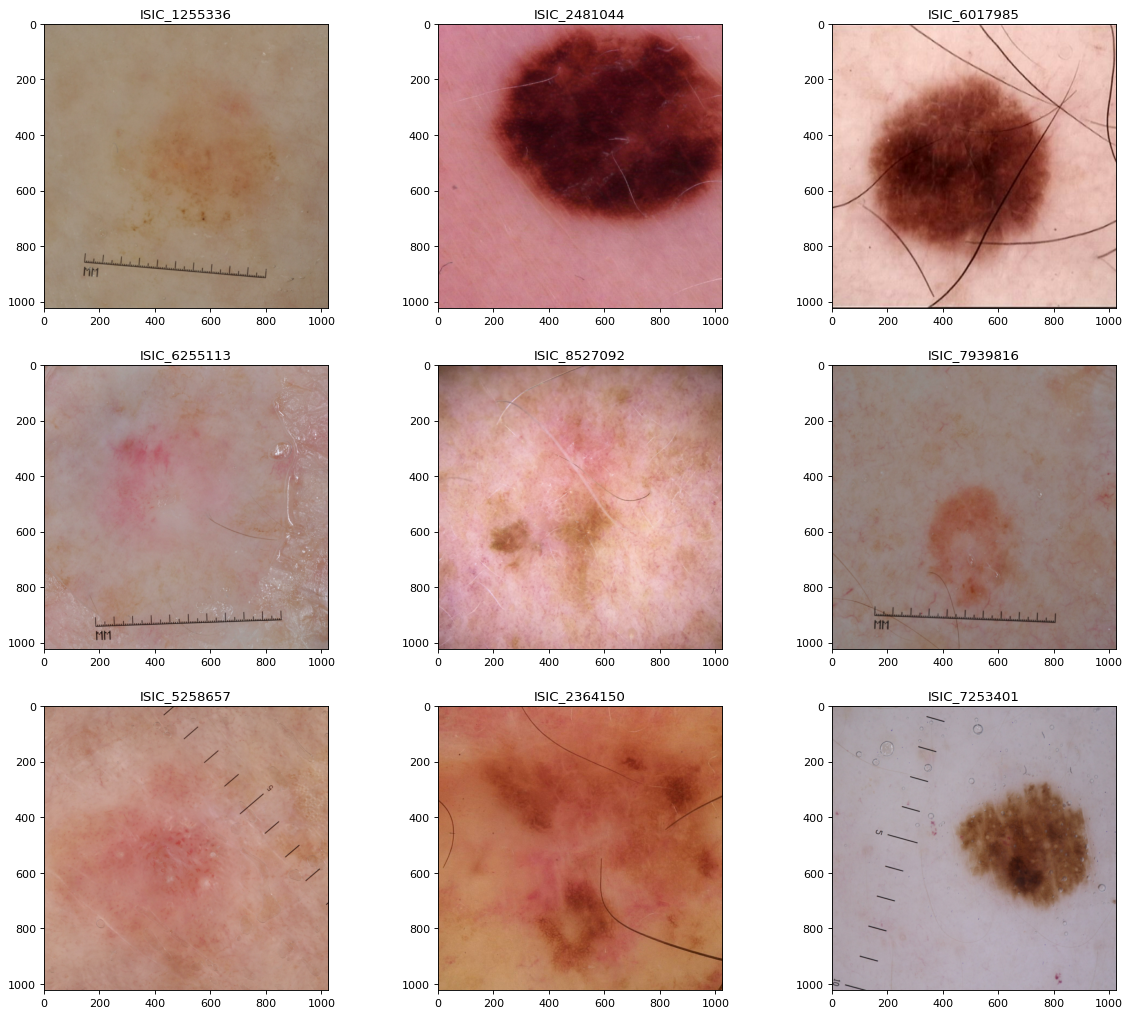

In [29]:
# Display positive targets in sample
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
site = int(330)
for i in p_indx[:9]:
  site = int(site+1)
  plt.subplot(int(site))
  plt.title(label[i])
  plt.imshow(image[i])


##Searching for contours and contour properties

See various sections of [this manual](https://opencv-python-tutroals.readthedocs.io/en/latest/index.html)

5.361865043640137


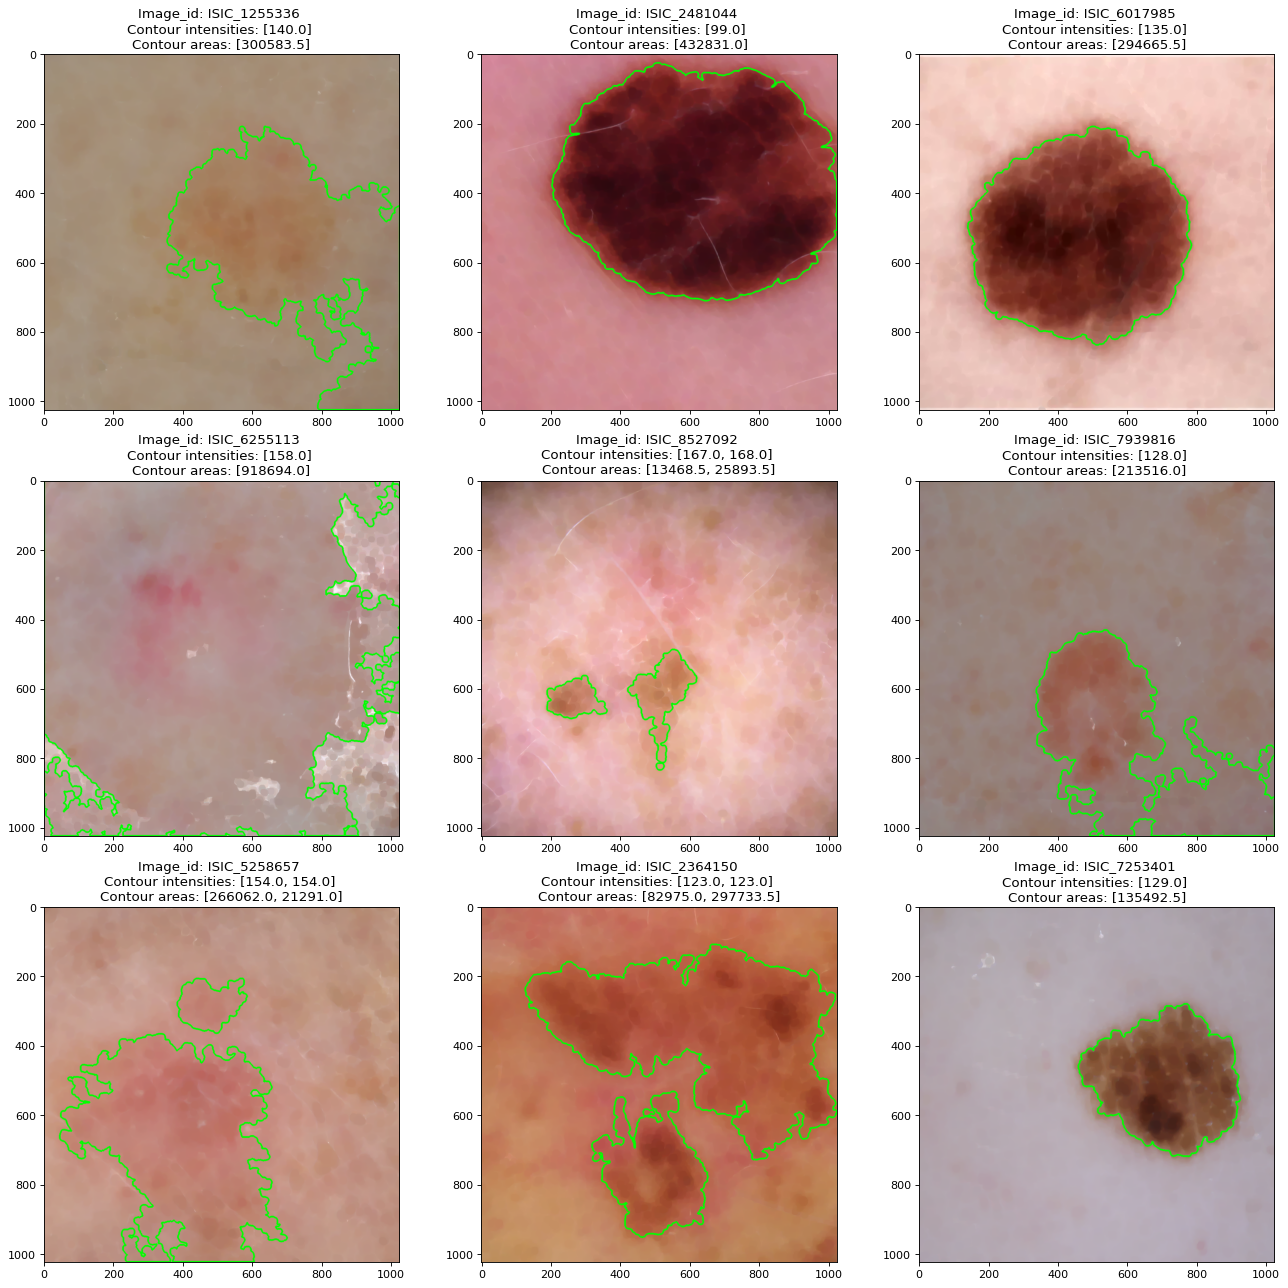

In [30]:
import cv2
# FINDING AND DRAWING THE RIGHT CONTOURS 

t0=time.time()

def cnt_area(cnt):
  # returns area enclosed by contour cnt
  return cv2.contourArea(cnt)

def ave_intensity(cnt,mask,img):
  # Returns average intensity in region enclosed by contour cnt
  mask1 = cv2.drawContours(mask,cnt,0,255,-1)
  return np.max(cv2.mean(img,mask = mask1))

def centroids(cnt):
  # Returns centroid coordinates for contour cnt
  M = cv2.moments(cnt)
  cx = int(M['m10']/M['m00'])
  cy = int(M['m01']/M['m00'])
  return [cx,cy]


def draw_contours(image):

  # Return imposed selected coutour images, their mean intensity and enclosed area
  # Intends to capture region(s) of interest
  #_______________________  

  # Remove hair from image
  kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (18,18))
  image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
  #-----------------------

  imr =(255*image).astype(np.uint8)

  # Convert RGB to BGR 
  im = imr[:, :, ::-1].copy() 

  imgray = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)

  #ret,thresh = cv2.threshold(imgray,80,255,0)
  ret,thresh = cv2.threshold(imgray,0,255, cv2.THRESH_BINARY_INV|cv2.THRESH_OTSU)
  contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)#_SIMPLE)#

  #edged = cv2.Canny(imgray, 30, 200) 
  #contours, hierarchy = cv2.findContours(edged,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
  
  cnts = contours[:]
  mask = np.zeros(imgray.shape,np.uint8)

  # Removing small contours
  cnts0 = [cnt for cnt in contours if cnt_area(cnt)>12000]
  #-------------------------

  # Removing contours too close to edges
  cnts1 = [cnt for cnt in cnts0 if 100<centroids(cnt)[0]<900]
  cnts = [cnt for cnt in cnts1 if 150<centroids(cnt)[1]<900]
  #-------------------------

  # filling contours mean intensity and area

  mean_val=[]
  area_val=[]
  
  for cnt in cnts:
    mask1 = cv2.drawContours(mask,cnt,0,255,-1)
    mean_val.append(ave_intensity(cnt,mask,imgray))
    area_val.append(cnt_area(cnt))

  #min_int = np.min(mean_val)
  #min_indx = mean_val.index(min_int)
  #------------------------------

  # Imposing contours on image
  img = cv2.drawContours(imr, cnts, -1, (0,255,0), 3)

  return img, cnts, hierarchy, mean_val, area_val

# DISPLAY POSITIVES WITH CONTOURS
fig=plt.figure(figsize=(20, 20), dpi= 80, facecolor='w', edgecolor='k')
site = int(330)
for i in p_indx[:9]:
  site = int(site+1)
  plt.subplot(int(site))
  img = draw_contours(image[i])[0]
  plt.title('Image_id: %s \nContour intensities: %s \nContour areas: %s'
  %(label[i],draw_contours(image[i])[3],draw_contours(image[i])[4]))
  plt.imshow(img)

t1=time.time()

print(t1-t0)


### Creating new image-based features

In [32]:
# Toy dataframe
# three new columns? number of contours, total area, average intensity
t1=time.time()

N_contours = []
total_area = []
mean_intensity = []
#counter = 0
for im in image[:]:
  #counter = counter+1
  #print(counter)
  _, cnts, _, mean_val, area_val = draw_contours(im)
  N_contours.append(len(cnts))
  total_area.append(np.sum(area_val))
  m_int = np.sum([mean_val[i]*area_val[i] for i in range(len(cnts))])
  m_int = m_int/sum(area_val)
  mean_intensity.append(m_int)

toy_db = pd.DataFrame(data={'image_name': label, 'N_contours': N_contours, 'total_area': total_area, 
                      'mean_intesity': mean_intensity, 'target':target})

t1=time.time()

print(t1-t0)

toy_db.head()


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()


210.85275840759277


,image_name,N_contours,total_area,mean_intesity,target
0,ISIC_3139230,2,224600.5,105.000000,0
1,ISIC_1939931,3,208674.0,197.189945,0
2,ISIC_8681290,1,319303.5,179.000000,0
3,ISIC_5403296,2,81420.5,216.000000,0
4,ISIC_5598875,1,223252.5,103.000000,0
